# Trabajo práctico final
## Mellino, Natalia

## Ejercicio 1

Elegimos un dataset para clasificación que usa estadísticas de la NBA para predecir si un jugador novato va a durar más de 5 años en la liga.

Las columnas son las siguientes:

![Columnas](dataset/tabla.png)

El dataset consta de 21 columnas y 1340 filas. La columna que queremos predecir es la columna "TARGET_5Yrs" que indica si el jugador duró más de 5 años en la liga o no.

### a) Información relevante al origen de los datos y su importancia

- [Origen de los datos](https://data.world/exercises/logistic-regression-exercise-1).


### b) Pre-tratamiento de los datos


In [9]:
## Hacemos un overview de nuestro dataset
nba <- read.csv("dataset/nba_logreg.csv")
head(nba)

,Name,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,⋯,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,⋯,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
2,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,⋯,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
3,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,⋯,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
4,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,⋯,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
5,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,⋯,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
6,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,32.5,⋯,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0


Vamos a tratar de identificar si hay **valores faltantes** en el dataset.

In [10]:
## Veamos si hay valores faltantes en nuestro dataset
na_count <-sapply(nba, function(y) sum(length(which(is.na(y)))))
data.frame(na_count)

,na_count
,<int>
Name,0
GP,0
MIN,0
PTS,0
FGM,0
FGA,0
FG.,0
X3P.Made,0
X3PA,0


Observamos que tenemos 11 valores faltantes todos en la columna `X3P`. Esto puede ser debido a que el jugador no haya realizado ningún intento de triple en su carrera. Por lo tanto, vamos a reemplazar estos valores por 0.


In [11]:
## Reemplazamos los valores NaN que observamos por 0.
nba[is.na(nba)] <- 0


Otra cosa que podemos hacer es remover la columna con el nombre de los jugadores ya que no nos sirve para el análisis y no aporta información relevante.

In [12]:
nba <- nba[,-1]

Nuestras variables son todas numéricas por lo que no es necesario realizar ningún tipo de transformación de variables categóricas, nominales, cíclicas, etc.

Lo que sí debemos hacer para concluir la preparación de los datos es **normalizar** las variables. Esto es necesario para que todas las variables tengan la misma escala y no haya variables que dominen el modelo.

In [13]:
## Normalizamos las variables de nuestro dataset
nba[, -20] <- scale(nba[, -20])

In [14]:
head(nba)

,GP,MIN,PTS,FGM,FGA,FG.,X3P.Made,X3PA,X3P.,FTM,FTA,FT.,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-1.4003780,1.1766268,0.13734969,-0.01728751,0.4771691,-1.5428313,0.6577959,1.2438896,0.3644670,0.306218922,0.36134949,-0.03784084,-0.3981409,1.01047510,0.5178034,0.2375509,-0.53325890,0.07322684,0.1472830,0
2,-1.4577372,1.1164436,0.09145229,-0.37367621,0.2267160,-2.3737643,1.1790534,1.9031180,0.2710199,1.319137598,1.19280303,0.58606736,-0.6555016,-0.01893098,-0.3083320,1.4610676,1.17506366,0.30630040,0.5624846,0
3,0.7792719,-0.2798071,-0.36752175,-0.37367621,-0.3298462,-0.3208710,0.3971671,0.8671876,0.3270881,-0.402824151,-0.39451737,-0.31198232,-0.6555016,-0.23951799,-0.4055244,-0.3742074,-0.28921282,-0.15984672,-0.2679187,0
4,-0.1384754,-0.7251629,-0.25277824,-0.19548186,-0.1072213,-0.2556998,-0.3847192,-0.2629183,0.2149516,-0.402824151,-0.39451737,-0.13237238,-0.0120998,-0.82775004,-0.5513130,-0.5101537,-0.04516674,-0.62599384,-0.2679187,1
5,-0.7120675,-0.7371995,-0.52816266,-0.61126868,-0.8029241,1.3409951,-0.6453479,-0.6396203,-1.1929849,0.002343319,0.05900274,-0.27416970,-0.0120998,-0.38657600,-0.2597358,-0.8500194,-0.77730498,0.07322684,-0.5447197,1
6,0.8366311,-0.7492362,-0.71175228,-0.67066679,-0.6637835,-0.3045782,0.1365384,0.3021347,0.8317025,-0.909283489,-0.99921086,0.27411326,-1.0415427,-0.97480805,-1.0858712,0.1695778,-0.53325890,-0.85906740,-0.6831203,0


### c) Análisis de los datos

Observemos que tenemos muchas columnas. Es necesario hacer un análisis gráfico de los datos para ver si podemos identificar a simple vista variables importantes (o no importantes) y como están distribuidas las clases para ver si hay desbalance.


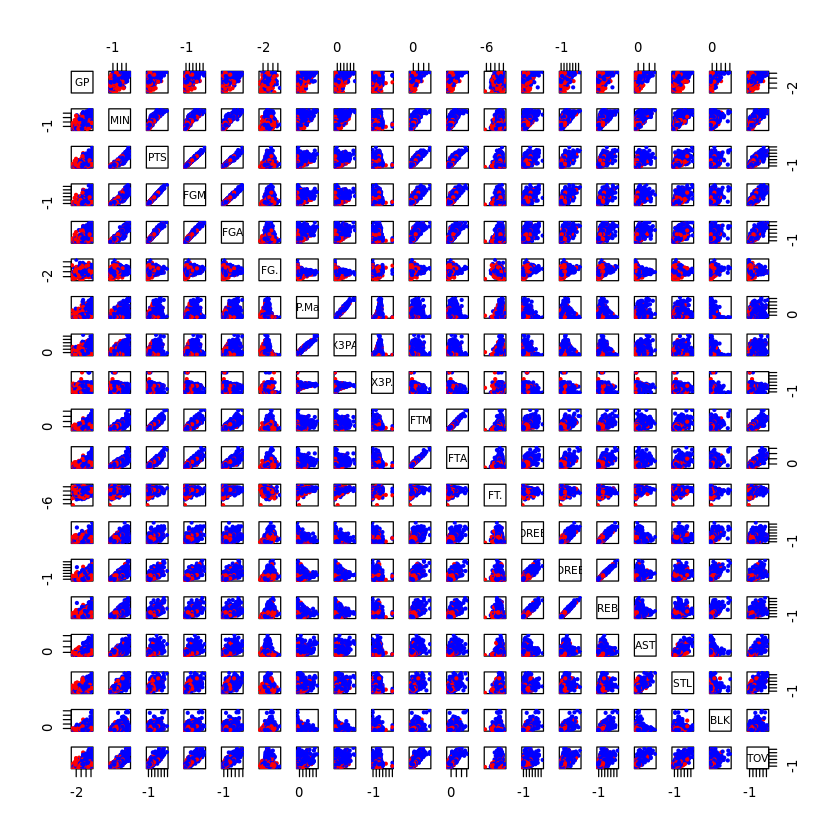

In [20]:
## Hacemos un plot de las variables comparándolas 1 a 1
nba.pairs.plot <- pairs(nba[, -20], pch = 19, cex = 0.5, col=c("red", "blue")[nba$TARGET_5Yrs+1])

Como se ve muy pequeña la imagen, guardamos este plot aparte y se puede visualizar mejor en `dataset/output.png`. Podemos ver un par de variables con una gran correlación. Vamos a graficarlas para observarlas en más detalle.

- DREB y REB
- PTS FGM
- FGM y FGA
- X3Made y X3PA